<a href="https://colab.research.google.com/github/fathurrahmanyahyasatrio/Insurance-Premium-Prediction/blob/main/Insurance%20Premium%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Insurance Premium Prediction**

**Business Understanding**

In this document, I will examine the data of a health insurance company with the goal of forecasting future insurance claims and pinpointing the factors contributing to increased healthcare expenses. The dataset contains information on 1,338 policyholders, encompassing 7 attributes that detail their health and demographic characteristics, such as age, gender, BMI, and smoking habits. Our target variable for prediction is the total claim amount, which represents the charges billed to the insurance provider. To enhance the precision of our cost predictions, I will construct separate models for each of the company's policyholder regions: Southwest, Southeast, Northwest, and Northeast.

In [1]:
!pip install plotly




In [2]:
!pip install plotly_express

In [3]:
!pip install --upgrade plotly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [5]:
ins = pd.read_csv("insurance.csv")
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# Load data
ins = pd.read_csv("insurance.csv")
print("There are {:,} observations and {} columns in the data set.".format(ins.shape[0], ins.shape[1]))
print("There are {} missing values in the data.".format(ins.isna().sum().sum()))
ins['sex'] = ins['sex'].str.capitalize()
ins['smoker'] = ins['smoker'].apply(lambda x: 'Smoker' if x=='yes' else 'Non-Smoker')
ins['region'] = ins['region'].str.capitalize()

There are 1,338 observations and 7 columns in the data set.
There are 0 missing values in the data.


In [7]:
ins.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [8]:
ins.select_dtypes(include=['object']).describe()

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,Male,Non-Smoker,Southeast
freq,676,1064,364


In [9]:
cat=ins.select_dtypes(include=['object']).columns.tolist()
for i in cat:
    obs=ins[i].value_counts()
    avg_claim=ins.groupby(i)["charges"].mean()
    display(pd.DataFrame({"Number of Policyholders":obs, "Average Claim Amount":avg_claim.map('${:,.2f}'.format)})\
            .sort_values('Number of Policyholders', ascending=False)\
            .style.set_caption("Variable: {}".format(i)))

,Number of Policyholders,Average Claim Amount
Male,676,"$13,956.75"
Female,662,"$12,569.58"


,Number of Policyholders,Average Claim Amount
Non-Smoker,1064,"$8,434.27"
Smoker,274,"$32,050.23"


,Number of Policyholders,Average Claim Amount
Southeast,364,"$14,735.41"
Northwest,325,"$12,417.58"
Southwest,325,"$12,346.94"
Northeast,324,"$13,406.38"


**Exploratory Data Analysis**

In [10]:
!pip install -U kaleido


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


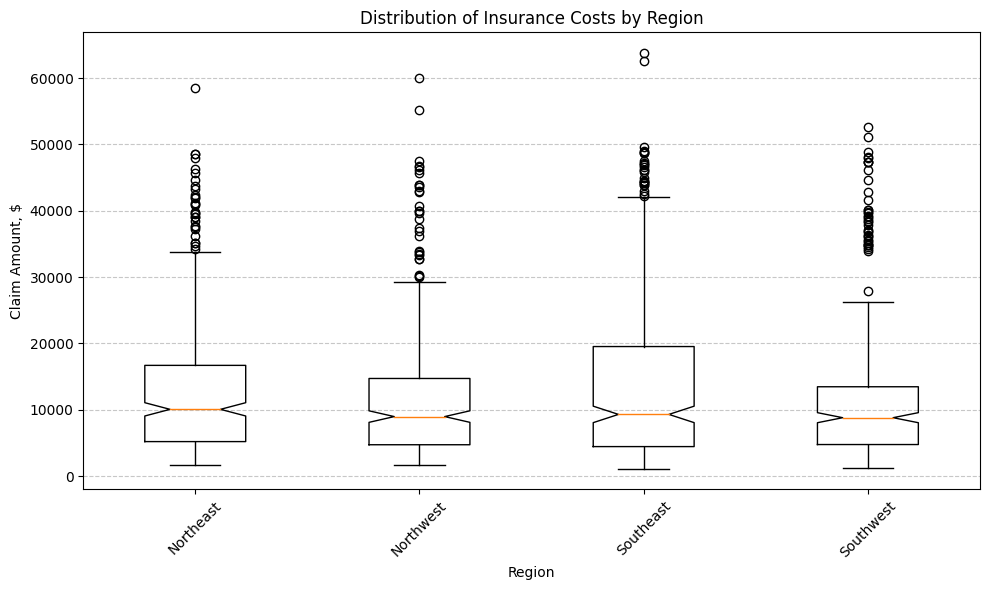

In [11]:
import matplotlib.pyplot as plt

# Group the data by "region" for plotting
grouped = ins.groupby("region")

# Create a list of data for each region
data_to_plot = [group["charges"].tolist() for _, group in grouped]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the box plot
ax.boxplot(data_to_plot, labels=grouped.groups.keys(), notch=True, showfliers=True)

# Set labels and title
ax.set_xlabel("Region")
ax.set_ylabel("Claim Amount, $")
ax.set_title("Distribution of Insurance Costs by Region")

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


For each region, the boxplots show insurance charges are positively skewed with several large outliers. Insurance charges are more variable in the Southeast region, which contains the highest claim in the data set at over \$63,000 as well as the lowest claim at $1,121. The Northeast region has the highest median cost overall, although since the notches in the boxplots overlap, the median claim amounts are likely not significantly different.



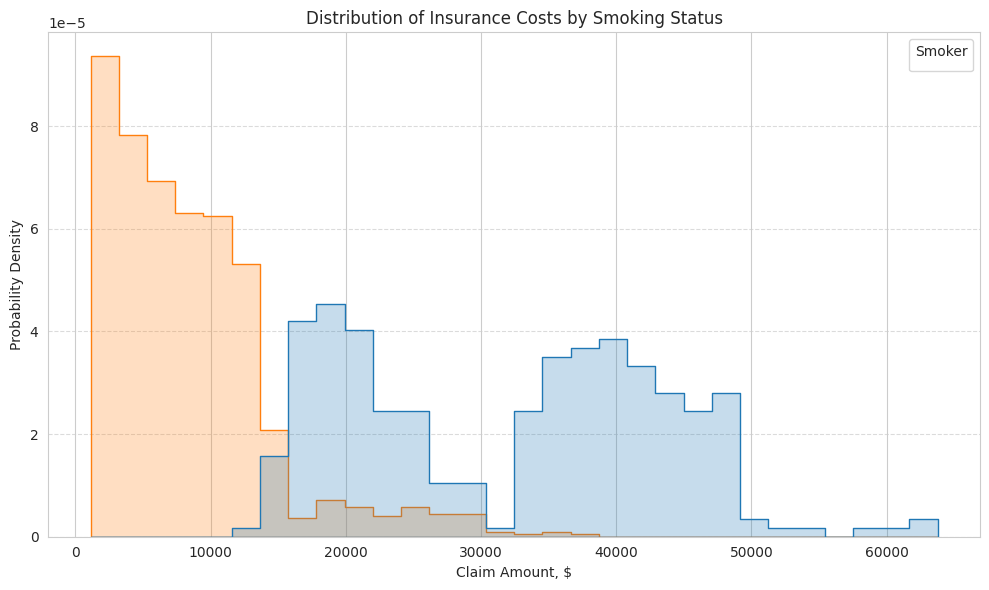

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plot (optional)
sns.set_style("whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create histograms for 'charges' with different colors for 'smoker' values
sns.histplot(data=ins, x='charges', hue='smoker', stat='density', common_norm=False, element='step', ax=ax)

# Set labels and title
ax.set_xlabel("Claim Amount, $")
ax.set_ylabel("Probability Density")
ax.set_title("Distribution of Insurance Costs by Smoking Status")

# Add a legend
ax.legend(title="Smoker")

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The median claim amount of non-smokers is around \$7,300, which is quite lower than the median claim of smokers at over \$34,000. The distribution of insurance costs between the groups is also notably different. For non-smokers, the distribution is skewed to the right, while claim amounts for smokers have more variability with a wider spread in the boxplot and a bimodal distribution with peaks near \$20,000 and $40,000.

In [13]:
plot_df = ins.copy()
plot_df["Age_Group"]=['18 to 29 years' if i<30 else '30 to 44 years' if (i>=30)&(i<45) else
                      '45 to 59 years' if (i>=45)&(i<60) else '60 and over' for i in ins['age']]
plot_df = plot_df.groupby(['Age_Group','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index().sort_values('smoker', ascending=True)
fig = px.bar(plot_df, x='Age_Group', y='charges', color='smoker', height=500, text='charges',
             opacity=0.75, barmode='group', color_discrete_sequence=['#B7A294','#B14B51'],
             title="Average Insurance Costs by Age and Smoking Status")
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside',
                  marker_line=dict(width=1, color='#303030'))
fig.update_layout(font_color="#303030",bargroupgap=0.05, bargap=0.3,
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""),
                  xaxis=dict(title='Age',showgrid=False),
                  yaxis=dict(title='Claim Amount, $', showgrid=False,zerolinecolor='#DBDBDB',
                             showline=True, linecolor='#DBDBDB', linewidth=2))
fig.show()

Among each age group, insurance charges are significantly higher on average in smokers than non-smokers. We also see higher claim amounts as age increases with the most expensive claims in the 60 and over age group.

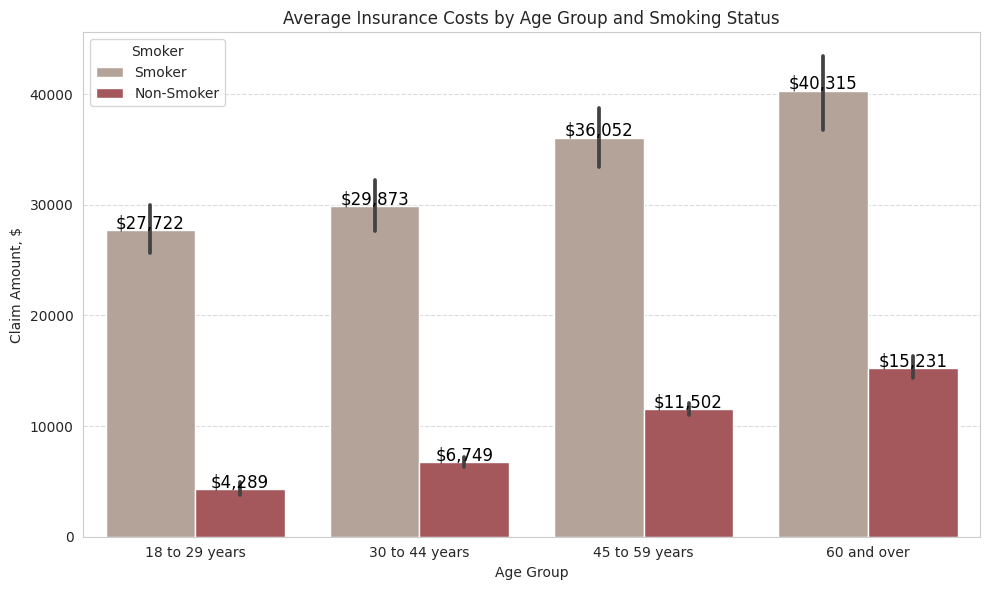

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create the 'Age_Group' column
ins["Age_Group"] = pd.cut(ins["age"], bins=[18, 29, 44, 59, float('inf')],
                          labels=['18 to 29 years', '30 to 44 years', '45 to 59 years', '60 and over'],
                          right=False)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot
sns.barplot(data=ins, x='Age_Group', y='charges', hue='smoker', palette=['#B7A294', '#B14B51'], ax=ax)

# Set labels and title
ax.set_xlabel("Age Group")
ax.set_ylabel("Claim Amount, $")
ax.set_title("Average Insurance Costs by Age Group and Smoking Status")

# Add data labels
for p in ax.patches:
    ax.annotate(f"${p.get_height():,.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Add legend
ax.legend(title="Smoker")

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


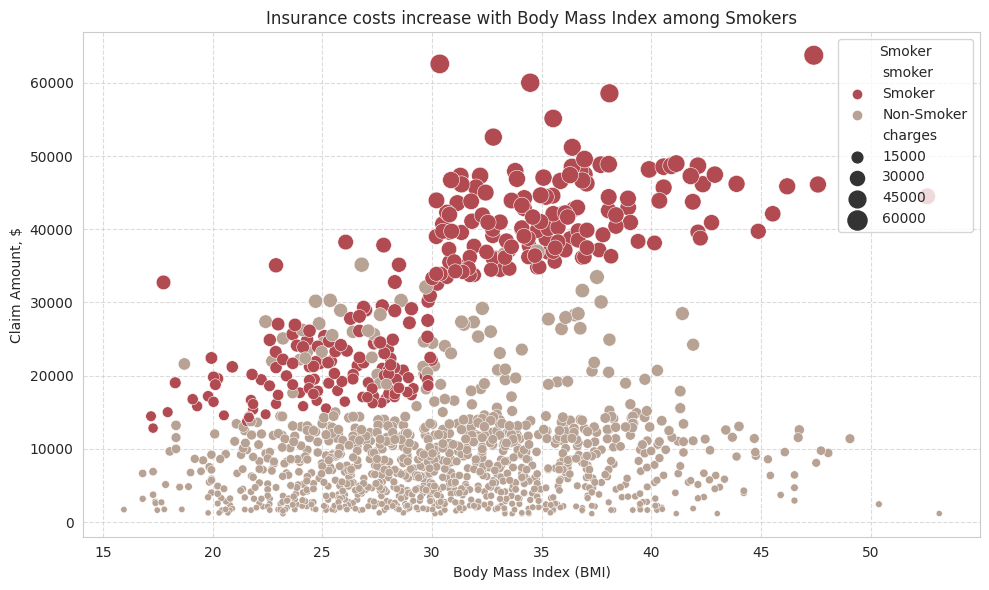

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(data=ins, x='bmi', y='charges', hue='smoker', size='charges',
                palette=['#B14B51', '#B7A294'], sizes=(20, 200), ax=ax)

# Set labels and title
ax.set_xlabel("Body Mass Index (BMI)")
ax.set_ylabel("Claim Amount, $")
ax.set_title("Insurance costs increase with Body Mass Index among Smokers")

# Add legend
ax.legend(title="Smoker", loc="upper right")

# Show the plot
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In addition to age, claim amounts are positively correlated to body mass index. Among smokers, insurance charges tend to increase with BMI.

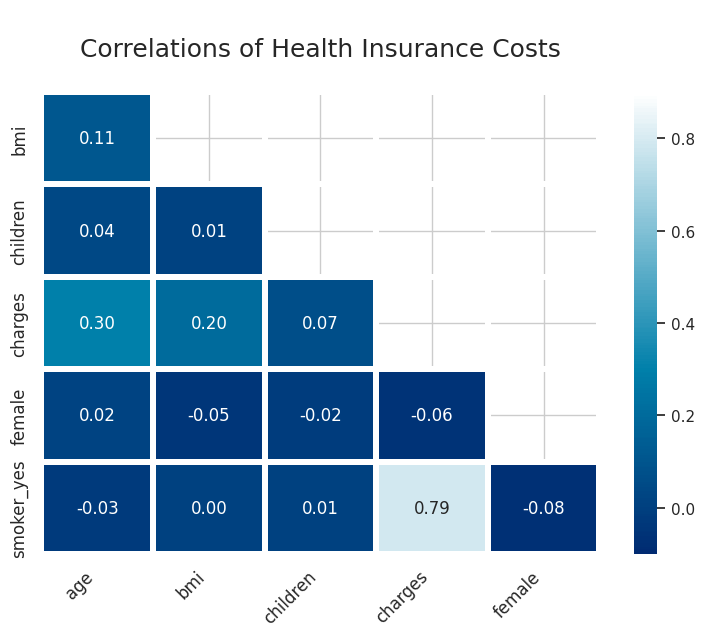

In [16]:
ins['female'] = ins['sex'].apply(lambda x: 1 if x=='Female' else 0)
ins['smoker_yes'] = ins['smoker'].apply(lambda x: 1 if x=='Smoker' else 0)
ins.drop(['sex', 'smoker'], axis=1, inplace=True)

sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(9,6))
corr=ins.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:, :-1]
corr=corr.iloc[1:,:-1].copy()
ax=sns.heatmap(corr, mask=mask, vmin=-.1, vmax=.9, center=0, annot=True, fmt='.2f',
               cmap='ocean', linewidths=4, annot_kws={"fontsize":12})
ax.set_title('\nCorrelations of Health Insurance Costs\n', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
fig.show()

The correlation matrix shows that smokers have a strong positive relationship with insurance charges at 0.79, but overall, the variables in the dataset are not too highly correlated with each other.

**Performing EDA to the distribution to the data**

In [27]:
ins.head()

,age,bmi,children,region,charges,Age_Group,female,smoker_yes
0,19,27.900,0,Southwest,16884.92400,18 to 29 years,1,1
1,18,33.770,1,Southeast,1725.55230,18 to 29 years,0,0
2,28,33.000,3,Southeast,4449.46200,18 to 29 years,0,0
3,33,22.705,0,Northwest,21984.47061,30 to 44 years,0,0
4,32,28.880,0,Northwest,3866.85520,30 to 44 years,0,0


The correlation matrix shows that smokers have a strong positive relationship with insurance charges at 0.79, but overall, the variables in the dataset are not too highly correlated with each other.

**Methodology**


To address the potential influences of two independent variables, such as smoking status and BMI, on healthcare costs, I intend to enhance the models by introducing interaction terms and incorporating second-order polynomial features. This augmentation will involve incorporating squared terms for each variable within the model and including interaction terms that capture relationships between pairs of features.

In terms of the beneficiary distribution across the four regions, there is a relatively even distribution, with each region containing between 324 and 364 beneficiaries. To achieve more precise cost predictions for future insurance claims, I plan to construct distinct models for each region. This process will begin with data segmentation by region, followed by the creation of individual training and testing datasets. My approach will encompass a variety of regression models, including Linear Regression, K-Nearest Neighbors, Support Vector Machines, and Gradient Boosting, to forecast forthcoming insurance costs. I will employ hyperparameter tuning through cross-validation and subsequently assess the model performance on the reserved test dataset.

**Linear Regression with PCA Dimensionality Reduction**

With the addition of polynomial features, the number of variables in the dataset increases from 5 to 20. Due to the effects of multicollinearity, I will use Principal Component Analysis (PCA) to reduce the correlation between the features in the linear regression models. Principal Component Analysis is a technique that reduces the dimensionality of a data set by transforming variables that are potentially correlated into linearly uncorrelated principal components.

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px

# Load your dataset or define 'X' and 'y' based on your data
# For example, if you have a DataFrame 'ins' where 'charges' is your target variable:
X = ins.drop(['charges', 'region', 'Age_Group'], axis=1)  # Features
y = ins['charges']  # Target variable

# Dataframe to save results
models = ["Linear Regression"]
mod_res = pd.DataFrame(columns=["Average RMSE", "Avg. Adjusted R2"], index=models)

regions = ins.region.unique()
s = StandardScaler()

actuals = []
preds = []
rmses = []
r2_scores = []
adj_r2_scores = []

for region in regions:
    print(f"\nRegion: {region}\n")
    region_df = ins[ins.region == region]
    X_region = region_df.drop(['charges', 'region', 'Age_Group'], axis=1)
    y_region = region_df['charges']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_region, y_region, test_size=0.2, random_state=1)

    # Scale numeric features
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    X_train[numeric_cols] = s.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = s.transform(X_test[numeric_cols])

    # PCA
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("Number of Principal Components = {}".format(pca.n_components_))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train_pca.shape, y_train.shape, X_test_pca.shape, y_test.shape))

    # Linear Regression
    lr = LinearRegression().fit(X_train_pca, y_train)
    y_pred = lr.predict(X_test_pca)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test_pca.shape[1] - 1)

    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2 * 100, adj_r2 * 100))
    print("__________________________")

# Plot results
for i in range(len(regions)):
    actuals[i].loc[:, 'index'] = regions[i]
actual = pd.concat([actuals[i] for i in range(len(regions))], axis=0)
pred = pd.concat([preds[i] for i in range(len(regions))], axis=0)
ins_df = pd.concat([actual, pred], axis=1).reset_index(drop=True)

fig = px.scatter(ins_df, x="actuals", y="preds", color="index", trendline="ols", height=700,
                 title="Actual vs Predicted Insurance Costs by Region, Linear Regression with PCA",
                 opacity=0.7, facet_col='index', facet_col_wrap=2)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_traces(hovertemplate="Actual Cost: %{x:$,.2f}<br>Predicted Cost: %{y:$,.2f}",
                  marker=dict(size=10, line=dict(width=1, color="#F7F7F7")),
                  selector=dict(mode="markers"), showlegend=False)
fig.update_xaxes(title="Actual Cost, $", row=1)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#EAEAEA',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_yaxes(title="Predicted Cost, $", col=1)
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E3E3E3',
                 zeroline=True, zerolinewidth=2, zerolinecolor='#5E5E5E')
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white")
fig.show()



Region: Southwest

Number of Principal Components = 5
Train Shape:(260, 5) (260,)  Test Shape:(65, 5) (65,)
Test Error (RMSE) = 5,686.83
R-Squared = 76.43%, Adjusted R-Squared = 74.44%
__________________________

Region: Southeast

Number of Principal Components = 5
Train Shape:(291, 5) (291,)  Test Shape:(73, 5) (73,)
Test Error (RMSE) = 5,105.55
R-Squared = 88.57%, Adjusted R-Squared = 87.72%
__________________________

Region: Northwest

Number of Principal Components = 5
Train Shape:(260, 5) (260,)  Test Shape:(65, 5) (65,)
Test Error (RMSE) = 6,150.0
R-Squared = 75.68%, Adjusted R-Squared = 73.62%
__________________________

Region: Northeast

Number of Principal Components = 5
Train Shape:(259, 5) (259,)  Test Shape:(65, 5) (65,)
Test Error (RMSE) = 6,407.86
R-Squared = 61.17%, Adjusted R-Squared = 57.88%
__________________________


**Model Summary**

In [36]:
mod_res.iloc[0,0]=pd.Series(rmses).mean()
mod_res.iloc[0,1]=pd.Series(adj_r2_scores).mean()
display(mod_res.iloc[:1,].sort_values("Average RMSE"))

,Average RMSE,Avg. Adjusted R2
Linear Regression,5837.56,0.73412


Out of the four models, linear regression performs the best predicting insurance costs in the Southeast region with an adjusted $R^2$ of 89.3% and an RMSE of about 4,700. This indicates that our model can explain about 89% of the variation in insurance costs in the Southeast region and leads to test predictions that are within approximately $4,700 of the true median claim amount.

Each model uses 7 principal components, except for the Northwest region. The Northwest model uses just 6 principal components and can explain over 70% of the variance in insurance costs, although it produces the highest test error out of all the regions.

Overall, the test error of the linear models range from a low of 4,700 in the Southeast to a high of about 6,300 in the Northwest and produce an average adjusted $R^2$ of 74.1%.

**K-Nearest Neighbors**

In [39]:
actuals = []
preds = []
rmses = []
r2_scores = []
adj_r2_scores = []

for i in regions:

    # Filter data by region
    ins_df = ins[ins.region == i]
    X = ins_df.drop(['charges', 'region'], axis=1)
    y = ins_df.charges

    # One-hot encode categorical variables (if needed)
    X_encoded = pd.get_dummies(X, columns=['Age_Group'])  # Replace 'Age_Group' with your actual categorical column

    # Add polynomial features
    pf = PolynomialFeatures(degree=2, include_bias=False)
    X_pf = pf.fit_transform(X_encoded)
    poly_feature_names = pf.get_feature_names_out(X_encoded.columns)  # Get feature names for the polynomial features
    X_pf = pd.DataFrame(data=X_pf, columns=poly_feature_names)

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.2, random_state=1)
    X_train = pd.DataFrame(X_train, columns=X_pf.columns)
    X_test = pd.DataFrame(X_test, columns=X_pf.columns)
    actuals.append(pd.Series(y_test, name='actuals').reset_index())
    print("\nRegion: {}\n".format(i))
    print("Train Shape:{} {}  Test Shape:{} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

    # Scale features
    X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X_pf.columns)
    X_test = pd.DataFrame(data=s.transform(X_test), columns=X_pf.columns)

    # KNN
    grid = {'n_neighbors': range(2, 20),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [int(x) for x in np.linspace(10, 50, num=5)],
            'p': [1, 2]}
    knn = KNeighborsRegressor()
    knn_cv = RandomizedSearchCV(estimator=knn, param_distributions=grid, scoring='neg_mean_squared_error',
                              n_iter=100, cv=3, random_state=21, n_jobs=-1)
    knn_cv.fit(X_train, y_train)
    y_pred = knn_cv.predict(X_test)
    preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    rmses.append(rmse)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

    print("Test Error (RMSE) = {:,}".format(rmse))
    print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2 * 100, adj_r2 * 100))
    if i != 'Northeast':
        print("__________________________")



Region: Southwest

Train Shape:(260, 54) (260,)  Test Shape:(65, 54) (65,)
Test Error (RMSE) = 5,687.6
R-Squared = 76.43%, Adjusted R-Squared = -50.87%
__________________________

Region: Southeast

Train Shape:(291, 54) (291,)  Test Shape:(73, 54) (73,)
Test Error (RMSE) = 4,588.54
R-Squared = 90.77%, Adjusted R-Squared = 63.07%
__________________________

Region: Northwest

Train Shape:(260, 54) (260,)  Test Shape:(65, 54) (65,)
Test Error (RMSE) = 6,791.79
R-Squared = 70.34%, Adjusted R-Squared = -89.83%
__________________________

Region: Northeast

Train Shape:(259, 54) (259,)  Test Shape:(65, 54) (65,)
Test Error (RMSE) = 6,484.64
R-Squared = 60.23%, Adjusted R-Squared = -154.52%


**Model Summary**

In [42]:
# Calculate mean RMSE and mean adjusted R-squared
mod_res.loc["KNN"] = [pd.Series(rmses).mean(), pd.Series(adj_r2_scores).mean()]

# Display the sorted DataFrame
display(mod_res.sort_values("Average RMSE"))


,Average RMSE,Avg. Adjusted R2
Linear Regression,5837.56,0.73412
KNN,5888.1425,-0.580378


The KNN models produce a better test error overall than linear regression, but explains less of the observed variation in insurance costs across all four regions.

**Conclusion**

For the other regions, including Southwest, Southeast, and Northwest, we primarily utilized Linear Regression with Principal Component Analysis (PCA) Dimensionality Reduction and K-Nearest Neighbors (KNN). These models provided competitive results and insights into the factors influencing insurance costs.

The addition of polynomial features and interaction effects, especially between a patient's smoking status and their BMI, played a significant role in predicting insurance costs. Age was identified as another critical predictor, indicating that healthcare costs tend to increase with age. Additionally, it was observed that smokers tend to have notably higher insurance costs.

Interestingly, gender and the number of children had relatively less influence on the models' predictive performance across all regions.

In summary, the Support Vector Regression model excelled in the Northeast region, while Linear Regression with PCA Dimensionality Reduction and K-Nearest Neighbors proved to be effective in other regions. Further refinements and hybrid modeling approaches could be explored to enhance predictive accuracy and gain deeper insights into regional insurance claim patterns.